# Logistic Regression 

<p>The following notebook provides an example code of predicting whether <b>the client will subscribe to a term deposit or not </b> using ogistic regression.
The dependent variable is <b>Y (subscribing the term deposit) (1-"Yes", 0-"No")</b>. The aim is to practice sklearn framework using Logistic Regression in the analysis. 
    
<br>The general sequence of steps for the analysis the following:
1. [Descriptive analysis]
2. [Feature Engineering] (categorize age, education (high/middle), log nr_employed, check correlation, campaign/duration, cons_price_idx/cons_conf_idx,categorize job (ex. managerial or not), get the season based on the month)
3. [Train/test split]
4. [Model Building]
5. [Hyperparameter tuning]
6. [Cross-Validation]

 <h2>1. Descriptive analysis</h2> <a name="pandas"></a>

The initial data consists of 4119 observations of 21 variables. There are no duplicates, missing values and variables with single value for all observations.
As the main models to be used are a non-parametric (DT and RF), we are not going to dive deep into the correlations and data manipulation as we used to do. 
Deposit subscription is not evenly balanced between 0s and 1s. As the countplot and value counts show, only about 11% of employees are subscribing and ~89% are not. So we can use this info as a naive assumption for newcomers to decide whether they'll leave or stay. In other words, if the resulting score is more than the noted value, then our model will be not bad, otherwise-a bad one. 

In [277]:
#data manipulation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#libraries for modelling and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve
import scikitplot as skplt #in case of error run "pip install scikit-plot" in cmd(terminal) and run the code again

In [278]:
data=pd.read_csv('MARKETING_FINANCE_Bank_targeting_default.csv')

In [279]:
#data overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp_var_rate    4119 non-null   float64
 16  cons_price_idx  4119 non-null   float64
 17  cons_conf_idx   4119 non-null   f

In [280]:
#have a look at first rows of the dataframe
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,30,blue_collar,married,basic_9y,no,yes,no,cellular,may,fri,...,2,0,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high_school,no,no,no,telephone,may,fri,...,4,0,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high_school,no,yes,no,telephone,jun,wed,...,1,0,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic_9y,no,unknown,unknown,telephone,jun,fri,...,3,0,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin_,married,university_degree,no,yes,no,cellular,nov,mon,...,1,0,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


In [281]:
data.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,0.227725,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695,0.109493
std,10.313362,254.703736,2.568159,1.369053,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904,0.312294
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000,0.000000
25%,32.000000,103.000000,1.000000,0.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000,0.000000
50%,38.000000,181.000000,2.000000,0.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,317.000000,3.000000,0.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,88.000000,3643.000000,35.000000,21.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [282]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:",data.duplicated().sum())
print("Missing values:",data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index([], dtype='object')


In [283]:
#lets count the benchmark for deposit subscription distribution
data.y.value_counts(normalize=True).mul(100).rename("Deposit subscription distribution")

0    89.05074
1    10.94926
Name: Deposit subscription distribution, dtype: float64

 <h2>2. Feature Engineering</h2> <a name="stats"></a>

In [284]:
data_num=data.select_dtypes(exclude="object")
data_obj=data.select_dtypes(include="object")

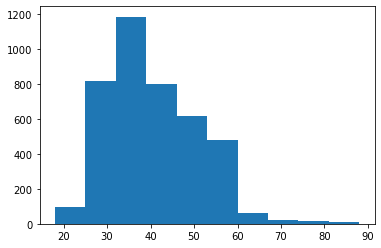

In [285]:
plt.hist(data_num['age'])
plt.show()

In [286]:
# age categories based on histogram approximation
data_num['age_cat'] = np.where(data_num['age']<30,1,np.where(data_num['age']<40,2,np.where(data_num['age']<60,3,4)))

<ipython-input-286-c90e38c6edfb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_num['age_cat'] = np.where(data_num['age']<30,1,np.where(data_num['age']<40,2,np.where(data_num['age']<60,3,4)))


In [287]:
data_obj['education'].value_counts()

university_degree      1264
high_school             921
basic_9y                574
professional_course     535
basic_4y                429
basic_6y                228
unknown                 167
illiterate                1
Name: education, dtype: int64

In [288]:
# education categories based on general knowledge
data_obj['education'] = np.where(data_obj['education'].isin(['unknown','illiterate']), 'unknown', 
                        np.where(data_obj['education'].isin(['basic_6y','basic_4y']), 'basic_4y', 
                        np.where(data_obj['education'].isin(['high_school','basic_9y']), 'high_school',
                                 'university_degree')))

<ipython-input-288-8b1a57b24284>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_obj['education'] = np.where(data_obj['education'].isin(['unknown','illiterate']), 'unknown',


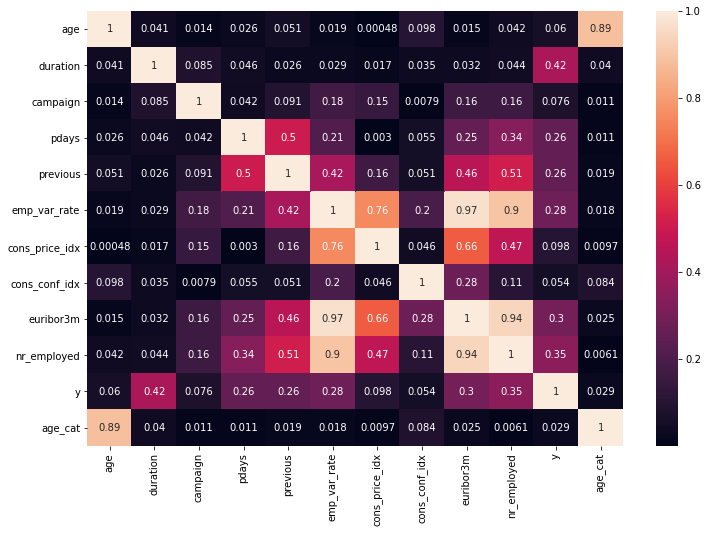

In [289]:
plt.figure(figsize=(12,8))
sns.heatmap(data_num.corr().abs(), annot=True)
plt.show()

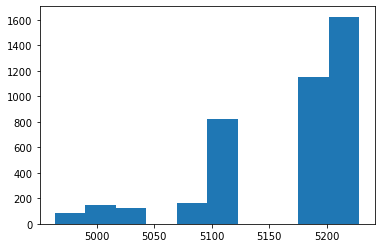

In [290]:
plt.hist(data_num.nr_employed)
plt.show()

In [291]:
# nr_employed categories based on histogram approximation
data_num['nr_employed'] = np.where(data_num['nr_employed']<5050,1, np.where(data_num['nr_employed']<5150,2,3))

<ipython-input-291-63feaf7dc05f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_num['nr_employed'] = np.where(data_num['nr_employed']<5050,1, np.where(data_num['nr_employed']<5150,2,3))


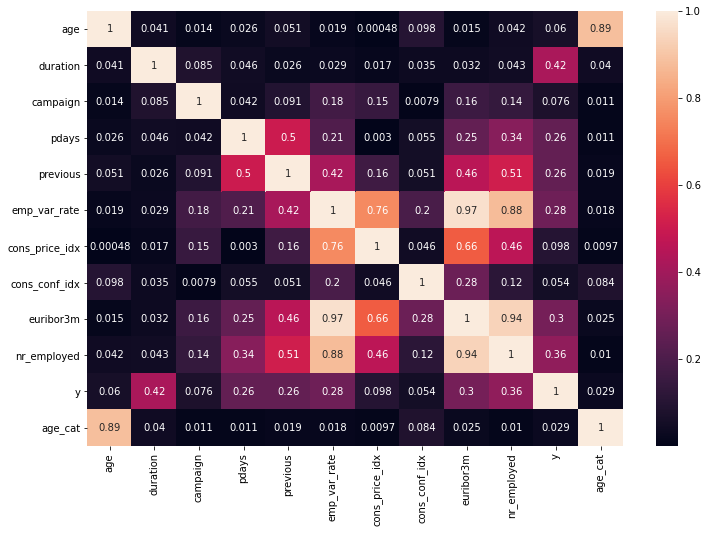

In [292]:
# recheck the correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(data_num.corr().abs(), annot=True)
plt.show()

In [293]:
# drop "euribor3m" as it has the highest correlation with "emp_var_rate" & "nr_employed", to solve multicollinarity
data_num = data_num.drop('euribor3m', axis=1)

In [294]:
# create several ratios
# Please note that we add a very small value to all the numbers in order not have 0 in a denominator
data_num['campaign_duration'] = data_num['campaign']/(data_num['duration']+0.001)
data_num['price_conf'] = data_num['cons_price_idx']/(data_num['cons_conf_idx']+0.001)

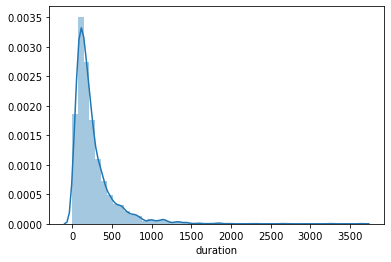

In [295]:
# check the distribution of duration
sns.distplot(data_num.duration)
plt.show()

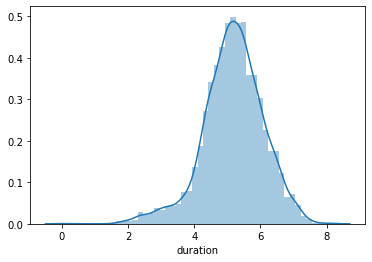

In [296]:
# check the log-distribution of duration, after log it became more normal
sns.distplot(np.log1p(data_num.duration))
plt.show()

In [297]:
data_num['duration'] = np.log1p(data_num.duration)

In [298]:
# create 'season' variable and drop months
data_obj['season'] = np.where(data_obj['month'].isin(['dec','jan', 'feb']), 'winter', 
                    np.where(data_obj['month'].isin(['mar','apr', 'may']),'spring', 
                    np.where(data_obj['month'].isin(['jun','jul', 'aug']), 'summer','fall')))
data_obj = data_obj.drop('month', axis=1)

<ipython-input-298-bff9ce6dd487>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_obj['season'] = np.where(data_obj['month'].isin(['dec','jan', 'feb']), 'winter',


In [299]:
# create 'job' categories based on general knowledge 
data_obj['job'] = np.where(data_obj['job'].isin(['unemployed','student','uknown','retired']), 'not employed',
                np.where(data_obj['job'].isin(['entrepreneur','self_employed']),  'self_empl', 
                np.where(data_obj['job'].isin(['admin_','management']),'management',
                np.where(data_obj['job'].isin(['technician','blue_collar']),"hard_work", "services"))))

In [300]:
data_dummies=pd.get_dummies(data_obj, prefix=data_obj.columns,drop_first=True)
data=data_num.join(data_dummies)

<h2>3. Train/test split</h2> <a name="stats"></a>


In [301]:
#making dummes,separating X and Y, train test split
X=data.drop('y', axis=1)
Y=data.y

In [302]:
X0, X1, Y0, Y1=train_test_split(X,Y, test_size=0.25, random_state=42)

In [303]:
# scale the data 
scaler = StandardScaler()
scaler.fit(X0)
X0_scaled = pd.DataFrame(scaler.transform(X0), columns=X0.columns)
X1_scaled = pd.DataFrame(scaler.transform(X1), columns=X1.columns)

<h2>4. Model BuildinModel Building</h2> <a name="stats"></a>

In [304]:
logit=LogisticRegression(random_state=42)
logit.fit(X0_scaled,Y0)

LogisticRegression(random_state=42)

In [305]:
Y0_logit=logit.predict_proba(X0_scaled)[:,1]
Y1_logit=logit.predict_proba(X1_scaled)[:,1]

print("ROC_AUC Train for tuned Logit:",roc_auc_score(Y0,Y0_logit).round(2))
print("ROC_AUC Test for tuned Logit:",roc_auc_score(Y1,Y1_logit).round(2))

ROC_AUC Train for tuned Logit: 0.94
ROC_AUC Test for tuned Logit: 0.91


<h2>5. Hyperparameter tuning</h2> <a name="stats"></a>

In [306]:
#building GridSearch with Logistic Regression
logit_1=LogisticRegression(random_state=42)

param_logit = {'class_weight':[None, 'balanced'], 'C':np.linspace(1,10,20),
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

gs_logit=GridSearchCV(estimator=logit_1, param_grid=param_logit,
                      scoring="roc_auc", cv=5, verbose=1, n_jobs=-1).fit(X0_scaled,Y0)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   56.5s finished
/Users/arsinesarikyan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


### Here you can see the explanation of hyperparameters
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [307]:
#finding out the best parameters
best_params = gs_logit.best_params_
print(best_params)

{'C': 1.4736842105263157, 'class_weight': 'balanced', 'solver': 'sag'}


In [308]:
#building logit with best params and seeing the results
logit_grid=LogisticRegression(random_state=42, C=best_params['C'], class_weight=best_params['class_weight'],
                              solver=best_params['solver']).fit(X0_scaled,Y0)

Y0_logit=logit_grid.predict_proba(X0_scaled)[:,1]
Y1_logit=logit_grid.predict_proba(X1_scaled)[:,1]

/Users/arsinesarikyan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [309]:
print("ROC_AUC Train for tuned Logit:",roc_auc_score(Y0,Y0_logit).round(2))
print("ROC_AUC Test for tuned Logit:",roc_auc_score(Y1,Y1_logit).round(2))

ROC_AUC Train for tuned Logit: 0.94
ROC_AUC Test for tuned Logit: 0.91


In [321]:
coefs = pd.DataFrame({'feature':X0.columns.tolist(),'coef':logit.coef_[0].tolist()})
coefs['coef_abs']=coefs.coef.abs()
coefs=coefs.sort_values('coef_abs',ascending=False)

In [324]:
# you can't get p-values while using sklearn, so you should select features based on coefficients
coefs

,feature,coef,coef_abs
1,duration,2.133863,2.133863
5,emp_var_rate,-1.174541,1.174541
6,cons_price_idx,0.612433,0.612433
28,contact_telephone,-0.422867,0.422867
34,poutcome_success,0.408767,0.408767
7,cons_conf_idx,0.380208,0.380208
8,nr_employed,-0.295729,0.295729
14,job_self_empl,-0.225640,0.225640
18,marital_unknown,-0.217980,0.217980
33,poutcome_nonexistent,0.204504,0.204504


<h2>6. Cross-Validation</h2> <a name="stats"></a>

In [310]:
X_scaled = pd.DataFrame(scaler.transform(X), columns=X0.columns)

In [311]:
CV_scores = cross_val_score(estimator=logit_grid, X=X_scaled, y=Y, cv=5, scoring="roc_auc")
print(CV_scores)

/Users/arsinesarikyan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/arsinesarikyan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/arsinesarikyan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/arsinesarikyan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[0.91457766 0.92455344 0.93203149 0.91862435 0.93287858]


/Users/arsinesarikyan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [312]:
print("Mean 5-fold ROC AUC score for Tuned Logit", np.mean(CV_scores))

Mean 5-fold ROC AUC score for Tuned Logit 0.9245331020751728


<h2>ROC Curve, Gain and Lift charts for winning model</h2> <a name="stats4"></a>

In [313]:
#setting up the needed metrics
FPR, TPR, thresholds=roc_curve(Y1, Y1_logit)

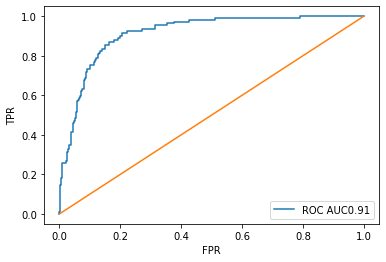

In [314]:
#plotting ROC AUC for Logistic Regression
plt.plot(FPR, TPR, label=f"ROC AUC{roc_auc_score(Y1, Y1_logit).round(2)}")
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [315]:
# Also we will plot gain and lift curve plots for the Logistic Regression

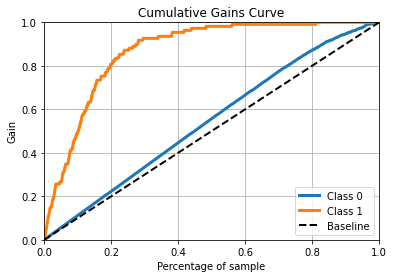

In [325]:
# this link explaines in detail the graph
# http://mlwiki.org/index.php/Cumulative_Gain_Chart
skplt.metrics.plot_cumulative_gain(Y1, logit_grid.predict_proba(X1_scaled))
plt.show()

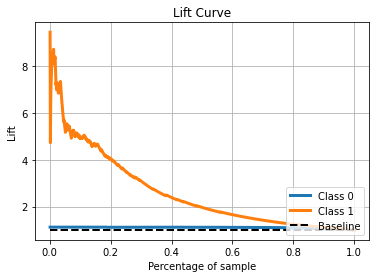

In [317]:
# this link explaines in detail the graph
# http://www2.cs.uregina.ca/~dbd/cs831/notes/lift_chart/lift_chart.html
skplt.metrics.plot_lift_curve(Y1,logit_grid.predict_proba(X1_scaled))
plt.show()